In [15]:
!pip install rdkit

# **CUDA-Q for Quantum-Based Molecule Generation**

Overview of the quantum-based molecular generator (QMG) construction process. a. The dynamic quantum circuit ansatz has multiple parameterized singe-qubit and controlled rotation gates. A scaffold-retained generation scheme allows specific gate parameters to be fixed, ensuring the presence of desired functional groups or substructures. The measured output is then reassembled into valid 2D molecular graphs with stereochemical details, and Bayesian optimization (BO) refines the circuit parameters to optimize the objective functions. b. An illustration figure of 3-heavy atom QMG with a total of 6 qubits. This circuit demonstrates the qubit reuse technique and dynamic operations based on mid-circuit measurement outcomes (purple box).  
<img src="./images/QMG_Figure_1.svg" width="1000" />

For detailed studies, please refer to the following paper: Chen, L. Y., Li, T. Y., Li, Y. P., Chen, N. Y., & You, F. (2025). Exploring Chemical Space with Chemistry-Inspired Dynamic Quantum Circuits in the NISQ Era. ***Journal of Chemical Theory and Computation***. https://pubs.acs.org/doi/full/10.1021/acs.jctc.5c00305

---

## 1. Introduction of dynamic quantum circuit for molecular generator
<img src="./images/QMG_Figure_2.svg" width="1000" />

## 2. Quantum-Based Molecule Generation for 3 Heavy Atoms

### Preparation

In [1]:
import cudaq
from util_qmg import MoleculeQuantumStateGenerator, draw_top_molecules
import random
import numpy as np

### Setup and Create weight parameters

In [2]:
num_heavy_atom = 3
length_all_weight_vector = int(8 + (num_heavy_atom - 2)*(num_heavy_atom + 3) * 3 / 2)
random.seed(10)

In [3]:
all_weight_vector = np.array([random.random() for _ in range(length_all_weight_vector)])
if num_heavy_atom>=3:
    used_part = 8
    for heavy_idx in range(3, num_heavy_atom+1):
        used_part += 3 
        num_fixed = heavy_idx-1
        num_flexible = 2*num_fixed
        bond_type_fixed_part = all_weight_vector[used_part: used_part+num_fixed]

        bond_type_fixed_part /= 0.2
        exps = np.exp(bond_type_fixed_part)
        bond_type_fixed_part_tmp = exps / np.sum(exps)

        all_weight_vector[used_part: used_part+num_fixed] = bond_type_fixed_part_tmp
        bond_type_flexible_part = all_weight_vector[used_part+num_fixed: used_part+num_fixed+num_flexible]
        bond_type_flexible_part *= 0.5
        bond_type_flexible_part += np.array([0, 0.5]*(heavy_idx-1))
        all_weight_vector[used_part+num_fixed: used_part+num_fixed+num_flexible] = bond_type_flexible_part
        used_part += num_fixed + num_flexible

In [4]:
all_weight_vector

array([0.57140259, 0.42888905, 0.5780913 , 0.20609823, 0.81332125,
       0.82358887, 0.65347253, 0.16022956, 0.52066936, 0.32777281,
       0.24999668, 0.44554178, 0.55445822, 0.02227819, 0.93008052,
       0.30159531, 0.69080299])

### Build Quantum-Based Molecule Generation(QMG) Kermel

In [5]:
@cudaq.kernel
def QMG_kernel(weight_vector: list[float]):
    # qubits 容器
    q = cudaq.qvector(6)

    # atom 1 & 2 quantum circuit
    ry(np.pi * weight_vector[0], q[0])
    x(q[1])
    ry(np.pi * weight_vector[2], q[2])
    ry(np.pi * weight_vector[4], q[3])
    cx(q[0], q[1])
    cry(np.pi * weight_vector[3], q[1], q[2])
    cx(q[2], q[3])
    cry(np.pi * weight_vector[1], q[0], q[1])
    cx(q[1], q[2])
    cry(np.pi * weight_vector[5], q[2], q[3])

    # 量測 atom1, atom2
    atom1 = mz(q[:2], register_name='qmg_result')  # cbits 0~1
    atom2 = mz(q[2:4], register_name='qmg_result') # cbits 2~3

    # 建立 bond1_2
    if atom2[0] != 0 or atom2[1] != 0:
        ry(np.pi * weight_vector[6], q[4])
        x(q[5])
        cx(q[4], q[5])
        cry(np.pi * weight_vector[7], q[4], q[5])
    bond1_2 = mz(q[4:6], register_name='qmg_result') # cbits 4~5

    # reset all qubits
    reset(q)

    # atom3 quantum circuit
    if atom2[0] != 0 or atom2[1] != 0:
        ry(np.pi * weight_vector[8], q[0])
        ry(np.pi * weight_vector[9], q[1])
        cry(np.pi * weight_vector[10], q[0], q[1])
    atom3 = mz(q[0:2], register_name='qmg_result') # cbits 6~7

    # 建立 bond3_1 and bond3_2
    if atom3[0] != 0 or atom3[1] != 0:
        ry(np.pi * weight_vector[11], q[3])
        ry(np.pi * weight_vector[12], q[5])
        cry(np.pi * weight_vector[13], q[3], q[2])
        cry(np.pi * weight_vector[14], q[2], q[3])
        cry(np.pi * weight_vector[15], q[5], q[4])
        cry(np.pi * weight_vector[16], q[4], q[5])
    bond3_1 = mz(q[2:4], register_name='qmg_result') # cbits 8~9
    bond3_2 = mz(q[4:6], register_name='qmg_result') # cbits 10~11

### Sample and Draw the top molecules

In [6]:
num_sample = 1000
result = cudaq.sample(QMG_kernel, all_weight_vector, shots_count=num_sample)
qmg_counts = result.get_register_counts('qmg_result')
print("QMG Counts:", qmg_counts)

QMG Counts: { 010000000000:339 010101000000:1 010101010000:1 010101010001:2 010101110000:1 010101110010:1 010110000000:9 010110010000:1 010110010100:1 010110100000:3 010110110001:1 010110110010:1 010110110100:2 010110110101:2 011001000000:3 011001010000:1 011001010001:2 011001100000:2 011001100110:1 011001110101:1 011010000000:5 011010010000:2 011010100000:1 011010100001:2 011010100100:1 011010100101:2 011010110000:2 011010110001:1 011010110100:1 011011000000:1 011011110100:1 011101000000:2 011110000000:4 011110010110:1 011110100000:1 011110100100:1 011110110000:1 011110110001:1 100000000000:5 100101000000:13 100101010000:3 100101010100:1 100101100000:1 100101100100:1 100101100101:1 100101100110:1 100101110000:1 100101110001:4 100101110010:1 100101110100:3 100101110101:2 100101110110:3 100101110111:2 100110000000:28 100110010000:1 100110010001:3 100110010100:2 100110010101:3 100110100000:6 100110100001:4 100110100011:2 100110100101:1 100110110000:6 100110110001:9 100110110010:1 1001101

In [7]:
data_generator = MoleculeQuantumStateGenerator(heavy_atom_size=num_heavy_atom, ncpus=1, sanitize_method="strict")

smiles_dict = {}
num_valid_molecule = 0
for key, value in qmg_counts.items():
    key = key[::-1]
    key = "".join(key.split())
    smiles = data_generator.QuantumStateToSmiles(data_generator.post_process_quantum_state(key))
    smiles_dict[smiles] = smiles_dict.get(smiles, 0) + value
    if smiles:
        num_valid_molecule += value
validity = (num_valid_molecule) / num_sample
uniqueness = (len(smiles_dict.keys()) - 1) / num_valid_molecule
smiles_dict, validity, uniqueness

print(smiles_dict)
print("Validity: {:.2f}%".format(validity*100))
print("Uniqueness: {:.2f}%".format(uniqueness*100))

{None: 120, 'C.CO': 4, 'O=CO': 5, 'N=CO': 2, 'CC.N': 1, 'C=N.O': 1, 'C1NO1': 6, 'CC=N': 2, 'N#N': 1, 'NNO': 5, 'C1=CN1': 2, 'N=NO': 2, 'CNO': 2, '[nH]1oo1': 5, 'C.C=C': 1, 'C1OO1': 1, 'C1=NO1': 4, 'C=C=N': 1, 'COC': 3, 'CC': 1, 'C=O.O': 7, 'C=CN': 3, 'C=NN': 1, 'C=O': 33, 'NC=O': 10, 'NOO': 3, 'NON': 3, 'N=O.O': 12, 'C=N': 9, 'CN': 2, 'CN=O': 3, 'O': 5, 'NO': 27, 'C.C=N': 1, 'C1=NN1': 1, 'CC=O': 3, 'NCO': 4, 'N.NN': 1, 'NN=O': 19, 'ONO': 4, 'CO': 16, 'N=NN': 2, 'N=O': 86, 'C=CC': 1, 'C=C': 9, 'C#[N+][O-]': 1, 'O=NO': 11, 'C=O.N': 8, 'N': 133, 'C': 339, 'N.N=O': 13, 'C.NN': 1, 'CN=N': 1, 'N.NO': 10, 'CON': 6, 'NO.O': 4, '[nH]1[nH]o1': 4, 'C.C=O': 3, 'CO.N': 1, 'C.N=O': 7, 'NN': 3, 'C.CC': 1, 'N=N': 2, 'C=N.N': 1, 'C.NO': 1, 'C1=NN=1': 1, 'C=C.O': 3, 'C1NN1': 1, 'CO.O': 3, 'COO': 1, 'N=CN': 2, 'N1=NN1': 2, 'CCC': 2, 'N=C=O': 1}
Validity: 88.00%
Uniqueness: 8.30%


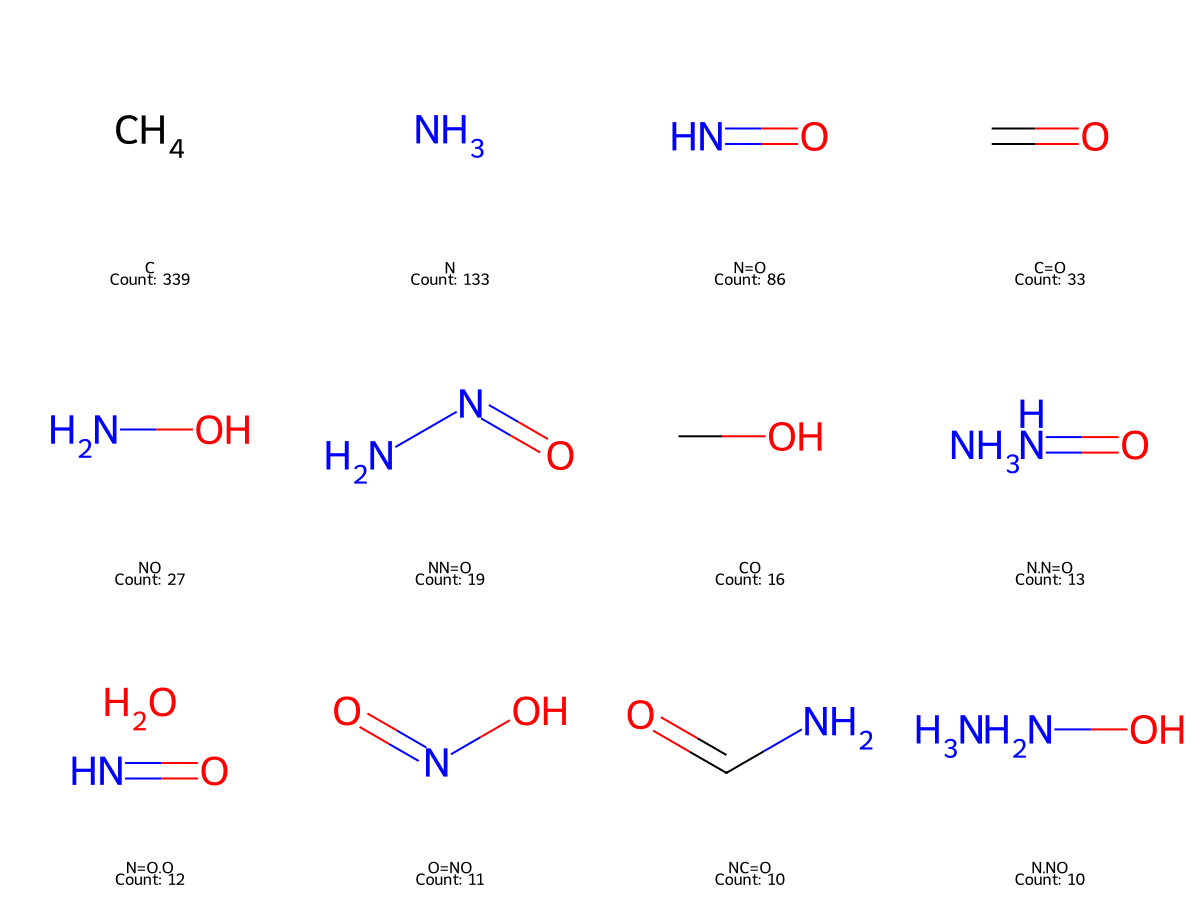

In [8]:
draw_top_molecules(smiles_dict, top_n=12, mols_per_row=4)

## 3. Backend Comparison

In [9]:
num_sample = 10000

- StateVector Simulation(CPU)

In [10]:
cudaq.set_target('qpp-cpu')

In [11]:
%%time
result = cudaq.sample(QMG_kernel, all_weight_vector, shots_count=num_sample)

CPU times: user 24.1 s, sys: 323 ms, total: 24.4 s
Wall time: 6.15 s


- StateVector Simulation(GPU)

In [12]:
cudaq.set_target('nvidia')

In [13]:
%%time
result = cudaq.sample(QMG_kernel, all_weight_vector, shots_count=num_sample)

CPU times: user 14.4 s, sys: 265 ms, total: 14.6 s
Wall time: 14.7 s
